### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.


Notes:
ideally, I want to use time-based cross-validation.
since I have panel data, it is not a trivial task.
need to find some solution online.
e.g., https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8.

for now, will try to do siple for loop.


In [333]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, math, re, warnings, random, gc, dill, optuna, pickle
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [334]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [335]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [336]:
# 1. Import data #

min_prd = 391

time0 = time.time()
#df = pd.read_csv('../input/cpcrsp-46/IMLEAP_v4.csv')
with open('../input/kaggle-46pkl/IMLEAP_v4.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
df = df[df.prd.isin(range(min_prd-1, min_prd+62))]
display(df.shape, df.head(), df.count())

(161139, 46)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
15,10005,390,NaN,-56.974664,1990,-40.6800,30.0,0.667021,-0.123134,0.0,-0.22093,26.592465,-6.891869,NaN,7.874195,6.946893,0.093336,21.135115,8.239788,7.983689,7.756113,NaN,-0.424011,0.490174,-0.214332,0.0,-0.230583,-0.934794,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-38.209694,5.565847,5.250996,0.663164,3.190628,2.799597
16,10005,391,NaN,-57.000479,1990,-0.5700,30.0,0.667021,-0.123134,0.0,-0.22093,-22.380465,55.680226,NaN,7.404275,6.612712,-0.150509,1.406600,0.866870,7.983689,7.756113,NaN,-0.934794,0.490174,-0.214332,0.0,-0.230583,-0.934794,NaN,21.135115,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,21.135115,NaN,-53.776947,0.765013,0.647098,0.372045,2.840962,2.265160
17,10005,392,NaN,-56.974664,1990,-0.6000,30.0,0.667021,-0.123134,0.0,-0.22093,-0.570000,-30.377554,NaN,0.765013,0.647098,-0.156073,1.406600,0.866870,7.983689,7.756113,NaN,-0.934794,0.490174,-0.214332,0.0,-0.230583,-0.647218,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-53.828083,6.739834,4.518291,0.526334,4.132793,3.099129
18,10005,393,NaN,-57.005640,1991,66.1467,30.0,0.667021,-0.123134,0.0,-0.22093,-0.600000,-30.349534,NaN,0.765013,0.647098,-0.197082,1.406600,0.866870,7.983689,7.756113,NaN,-0.938262,0.490174,-0.214332,0.0,-0.230583,-0.647218,NaN,1.406600,NaN,NaN,21.135115,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-38.367763,0.765013,0.647098,0.522012,4.132801,3.099129
19,10005,394,NaN,-28.214878,1991,-0.4800,30.0,0.667021,-0.123134,0.0,-0.22093,26.592465,-30.370549,NaN,7.874195,6.946893,-0.127235,21.135115,8.239788,7.983689,7.756113,NaN,-0.427479,0.490174,-0.214332,0.0,-0.230583,-0.647218,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-38.404947,0.765013,0.647098,0.499827,4.132835,3.099130


PERMNO          161139
prd             161139
mom482          139045
mom242          159125
year            161139
RET             161139
ind             161139
bm              161139
op              161139
gp              161139
inv             161045
mom11           161139
mom122          161139
amhd            124600
ivol_capm       161134
ivol_ff5        161134
beta_bw         161139
MAX             161139
vol1m           161123
vol6m           161039
vol12m          160822
BAspr           120393
size            161139
lbm             161139
lop             161139
lgp             161139
linv            161139
llme            161139
l1amhd          124489
l1MAX           161134
l1BAspr         118923
l3amhd          124312
l3MAX           161106
l3BAspr         115926
l6amhd          124095
l6MAX           161084
l6BAspr         111495
l12amhd         124082
l12MAX          161134
l12BAspr        102815
l12mom122       160515
l12ivol_capm    161029
l12ivol_ff5     161029
l12beta_bw 

<AxesSubplot:>

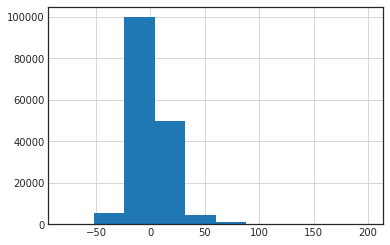

In [337]:
# 2. pEDA #

df.RET.hist()

In [338]:
# explore feature distibution, adjust if seems unreasonable

In [339]:
# add dummies for some missing features

features_miss_dummies = ['amhd', 'BAspr']

for col in features_miss_dummies:
    df[col+'_miss'] = df[col].isnull().astype(int)

df.head()

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
15,10005,390,NaN,-56.974664,1990,-40.6800,30.0,0.667021,-0.123134,0.0,-0.22093,26.592465,-6.891869,NaN,7.874195,6.946893,0.093336,21.135115,8.239788,7.983689,7.756113,NaN,-0.424011,0.490174,-0.214332,0.0,-0.230583,-0.934794,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-38.209694,5.565847,5.250996,0.663164,3.190628,2.799597,1,1
16,10005,391,NaN,-57.000479,1990,-0.5700,30.0,0.667021,-0.123134,0.0,-0.22093,-22.380465,55.680226,NaN,7.404275,6.612712,-0.150509,1.406600,0.866870,7.983689,7.756113,NaN,-0.934794,0.490174,-0.214332,0.0,-0.230583,-0.934794,NaN,21.135115,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,21.135115,NaN,-53.776947,0.765013,0.647098,0.372045,2.840962,2.265160,1,1
17,10005,392,NaN,-56.974664,1990,-0.6000,30.0,0.667021,-0.123134,0.0,-0.22093,-0.570000,-30.377554,NaN,0.765013,0.647098,-0.156073,1.406600,0.866870,7.983689,7.756113,NaN,-0.934794,0.490174,-0.214332,0.0,-0.230583,-0.647218,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-53.828083,6.739834,4.518291,0.526334,4.132793,3.099129,1,1
18,10005,393,NaN,-57.005640,1991,66.1467,30.0,0.667021,-0.123134,0.0,-0.22093,-0.600000,-30.349534,NaN,0.765013,0.647098,-0.197082,1.406600,0.866870,7.983689,7.756113,NaN,-0.938262,0.490174,-0.214332,0.0,-0.230583,-0.647218,NaN,1.406600,NaN,NaN,21.135115,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-38.367763,0.765013,0.647098,0.522012,4.132801,3.099129,1,1
19,10005,394,NaN,-28.214878,1991,-0.4800,30.0,0.667021,-0.123134,0.0,-0.22093,26.592465,-30.370549,NaN,7.874195,6.946893,-0.127235,21.135115,8.239788,7.983689,7.756113,NaN,-0.427479,0.490174,-0.214332,0.0,-0.230583,-0.647218,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-38.404947,0.765013,0.647098,0.499827,4.132835,3.099130,1,1


In [340]:
# 3. Train-test split #

temp_cols = ['PERMNO', 'prd', 'year']

train = df[df.prd<(min_prd+60)]
test = df[df.prd==(min_prd+60)]
train.drop(columns=temp_cols, inplace=True)
test.drop(columns=temp_cols, inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

(155745, 45)

(2704, 45)

,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
15,NaN,-56.974664,-40.68,30.0,0.667021,-0.123134,0.0,-0.22093,26.592465,-6.891869,NaN,7.874195,6.946893,0.093336,21.135115,8.239788,7.983689,7.756113,NaN,-0.424011,0.490174,-0.214332,0.0,-0.230583,-0.934794,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-38.209694,5.565847,5.250996,0.663164,3.190628,2.799597,1,1
16,NaN,-57.000479,-0.57,30.0,0.667021,-0.123134,0.0,-0.22093,-22.380465,55.680226,NaN,7.404275,6.612712,-0.150509,1.406600,0.866870,7.983689,7.756113,NaN,-0.934794,0.490174,-0.214332,0.0,-0.230583,-0.934794,NaN,21.135115,NaN,NaN,1.4066,NaN,NaN,1.4066,NaN,NaN,21.135115,NaN,-53.776947,0.765013,0.647098,0.372045,2.840962,2.265160,1,1
17,NaN,-56.974664,-0.60,30.0,0.667021,-0.123134,0.0,-0.22093,-0.570000,-30.377554,NaN,0.765013,0.647098,-0.156073,1.406600,0.866870,7.983689,7.756113,NaN,-0.934794,0.490174,-0.214332,0.0,-0.230583,-0.647218,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-53.828083,6.739834,4.518291,0.526334,4.132793,3.099129,1,1


,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
352,221.036390,71.141338,-9.5109,34.0,-2.486223,0.258106,0.875338,0.516551,-8.8033,4.809002,1.994961,4.082701,3.614374,0.889628,8.0435,4.223638,2.857356,3.429300,1.886792,4.388676,-1.862198,0.132619,0.757579,0.335288,4.334673,2.055711,3.4263,1.680672,2.158299,11.8414,3.816794,2.282986,17.0710,1.481481,3.937745,3.4263,1.550388,43.713086,2.723997,2.325965,0.670790,2.191232,2.755011,0,0
584,-20.644388,-14.451079,-3.5450,21.0,-0.251613,-0.024900,0.176579,-0.230583,-9.9040,65.805395,2.268093,1.479970,1.147467,0.836054,2.1067,1.480002,2.175121,3.150615,2.105263,5.098719,0.177905,-0.082748,0.119668,-0.103007,4.646416,2.330593,5.2920,1.923077,2.493890,11.7417,2.439024,2.455719,4.1437,2.898551,1.945916,5.2920,4.918033,-44.221641,2.446662,1.955686,0.806892,2.414122,3.739985,0,0
802,14.774473,0.128066,5.1356,22.0,-0.350772,0.080204,0.514015,0.044549,-12.6651,26.020433,3.902367,2.958742,2.530542,0.667538,4.9790,3.030023,3.543060,3.745831,2.702703,3.900517,-0.174981,0.079414,0.476869,0.132045,3.709154,4.167721,4.3258,4.819277,4.980164,3.7745,7.228916,5.256542,9.4110,4.081633,5.583447,4.3258,7.812500,-20.978555,4.569170,4.275598,1.398619,5.172389,5.055447,0,0


In [341]:
# 4. Missing values #

col_ignore = ['RET']
col_cat = ['ind']
col_num = [x for x in train.columns if x not in col_ignore+col_cat]

for col in col_num:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

for col in col_cat:
    train[col] = train[col].fillna(value=-1000)
    test[col] = test[col].fillna(value=-1000)
    
display(train.count())

mom482          155745
mom242          155745
RET             155745
ind             155745
bm              155745
op              155745
gp              155745
inv             155745
mom11           155745
mom122          155745
amhd            155745
ivol_capm       155745
ivol_ff5        155745
beta_bw         155745
MAX             155745
vol1m           155745
vol6m           155745
vol12m          155745
BAspr           155745
size            155745
lbm             155745
lop             155745
lgp             155745
linv            155745
llme            155745
l1amhd          155745
l1MAX           155745
l1BAspr         155745
l3amhd          155745
l3MAX           155745
l3BAspr         155745
l6amhd          155745
l6MAX           155745
l6BAspr         155745
l12amhd         155745
l12MAX          155745
l12BAspr        155745
l12mom122       155745
l12ivol_capm    155745
l12ivol_ff5     155745
l12beta_bw      155745
l12vol6m        155745
l12vol12m       155745
amhd_miss  

In [342]:
# [optional] Target Encoding

# first, do frequency encoding
freq_enc = (train.groupby('ind').size()) / len(train)
train['ind_fencoded'] = train['ind'].apply(lambda x : freq_enc[x])
test['ind_fencoded'] = test['ind'].apply(lambda x : freq_enc[x])

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.RET, cols=col_cat)
test_encoded = encoder.transform(test)

train.drop(columns=col_cat, inplace=True)
test.drop(columns=col_cat,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

3.176252603530884

1.099823236465454

(155745, 46)

,mom482,mom242,RET,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss,ind_fencoded,ind_encoded
15,-1.431704,-56.974664,-40.6800,0.667021,-0.123134,0.0,-0.22093,26.592465,-6.891869,2.954248,7.874195,6.946893,0.093336,21.135115,8.239788,7.983689,7.756113,3.921569,-0.424011,0.490174,-0.214332,0.0,-0.230583,-0.934794,2.965253,1.406600,3.947368,2.986047,1.406600,4.0,3.009939,1.4066,4.054054,3.048352,1.406600,4.123711,-38.209694,5.565847,5.250996,0.663164,3.190628,2.799597,1,1,0.063527,0.063301
16,-1.431704,-57.000479,-0.5700,0.667021,-0.123134,0.0,-0.22093,-22.380465,55.680226,2.954248,7.404275,6.612712,-0.150509,1.406600,0.866870,7.983689,7.756113,3.921569,-0.934794,0.490174,-0.214332,0.0,-0.230583,-0.934794,2.965253,21.135115,3.947368,2.986047,1.406600,4.0,3.009939,1.4066,4.054054,3.048352,21.135115,4.123711,-53.776947,0.765013,0.647098,0.372045,2.840962,2.265160,1,1,0.063527,0.063301
17,-1.431704,-56.974664,-0.6000,0.667021,-0.123134,0.0,-0.22093,-0.570000,-30.377554,2.954248,0.765013,0.647098,-0.156073,1.406600,0.866870,7.983689,7.756113,3.921569,-0.934794,0.490174,-0.214332,0.0,-0.230583,-0.647218,2.965253,1.406600,3.947368,2.986047,1.406600,4.0,3.009939,1.4066,4.054054,3.048352,1.406600,4.123711,-53.828083,6.739834,4.518291,0.526334,4.132793,3.099129,1,1,0.063527,0.063301
18,-1.431704,-57.005640,66.1467,0.667021,-0.123134,0.0,-0.22093,-0.600000,-30.349534,2.954248,0.765013,0.647098,-0.197082,1.406600,0.866870,7.983689,7.756113,3.921569,-0.938262,0.490174,-0.214332,0.0,-0.230583,-0.647218,2.965253,1.406600,3.947368,2.986047,21.135115,4.0,3.009939,1.4066,4.054054,3.048352,1.406600,4.123711,-38.367763,0.765013,0.647098,0.522012,4.132801,3.099129,1,1,0.063527,0.063301
19,-1.431704,-28.214878,-0.4800,0.667021,-0.123134,0.0,-0.22093,26.592465,-30.370549,2.954248,7.874195,6.946893,-0.127235,21.135115,8.239788,7.983689,7.756113,3.921569,-0.427479,0.490174,-0.214332,0.0,-0.230583,-0.647218,2.965253,1.406600,3.947368,2.986047,1.406600,4.0,3.009939,1.4066,4.054054,3.048352,1.406600,4.123711,-38.404947,0.765013,0.647098,0.499827,4.132835,3.099130,1,1,0.063527,0.063301


mom482          155745
mom242          155745
RET             155745
bm              155745
op              155745
gp              155745
inv             155745
mom11           155745
mom122          155745
amhd            155745
ivol_capm       155745
ivol_ff5        155745
beta_bw         155745
MAX             155745
vol1m           155745
vol6m           155745
vol12m          155745
BAspr           155745
size            155745
lbm             155745
lop             155745
lgp             155745
linv            155745
llme            155745
l1amhd          155745
l1MAX           155745
l1BAspr         155745
l3amhd          155745
l3MAX           155745
l3BAspr         155745
l6amhd          155745
l6MAX           155745
l6BAspr         155745
l12amhd         155745
l12MAX          155745
l12BAspr        155745
l12mom122       155745
l12ivol_capm    155745
l12ivol_ff5     155745
l12beta_bw      155745
l12vol6m        155745
l12vol12m       155745
amhd_miss       155745
BAspr_miss 

In [343]:
X_train = train.copy()
y_train = X_train.pop('RET')

X_test = test.copy()
y_test = X_test.pop('RET')

In [344]:
# 5. Feature engineering #

time1 = time.time()

# ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat),

feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num)], remainder="passthrough")

print('Number of features before transformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transformation: ', X_train.shape)



Number of features before transformation:  (155745, 45)
time to do feature proprocessing:  0.17090606689453125
Number of features after transformation:  (155745, 45)


In [345]:
# 6. Model fitting #

# first, some trivial baselines:
print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

time1 = time.time()
xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=5, eta=0.04, colsample_bytree=0.6)
xgb1.fit(X_train, y_train)
print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)), time.time()-time1)

mae of a constant model 10.795447332475286
R2 of a constant model 0.0
XGB train: 10.524598947835688 0.09155861878129534 2.899041175842285


In [346]:
time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[300, 500], 'max_depth':[2,3,4], 'eta':[0.01, 0.03, 0.05],
             'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='neg_mean_absolute_error')
xgbm.fit(X_train, y_train)
print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
# this runs for 40 min and finds 
# 'eta': 0.02, 'max_depth': 6, 'n_estimators': 500, 0.01095415380877135
print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=300, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=300, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=500, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=2, n_estimators=500, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, n_estimators=300, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, n_estimators=300, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, n_estimators=500, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, n_estimators=500, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=4, n_estimators=300, subsample=0.6; tota

In [347]:
# time1 = time.time()

# def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

#     cv_regularizer=0.01
#     # Usually values between 0.1 and 0.2 work fine.

#     params = {
#         "tree_method": 'gpu_hist',
#         "verbosity": 0,  # 0 (silent) - 3 (debug)
#         "n_estimators": trial.suggest_int("n_estimators", 100, 500),
#         "max_depth": trial.suggest_int("max_depth", 2, 10),
#         "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.2),
#         "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
#         "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
#         "alpha": trial.suggest_loguniform("alpha", 0.1, 20.0),
#         "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
#         "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
#         "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10)    }
#     # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
#     # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
#     # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

#     temp_out = []

#     for i in range(cv_runs):

#         X = X_train
#         y = y_train

#         model = XGBRegressor(**params, njobs=-1)
#         rkf = KFold(n_splits=n_splits, shuffle=True)
#         X_values = X.values
#         y_values = y.values
#         y_pred = np.zeros_like(y_values)
#         y_pred_train = np.zeros_like(y_values)
#         for train_index, test_index in rkf.split(X_values):
#             X_A, X_B = X_values[train_index, :], X_values[test_index, :]
#             y_A, y_B = y_values[train_index], y_values[test_index]
#             model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
#             y_pred[test_index] += model.predict(X_B)
                      
            
#         #score_train = roc_auc_score(y_train, y_pred_train)
#         score_test = mean_absolute_error(y_train, y_pred) 
#         #overfit = score_train-score_test
#         #temp_out.append(score_test-cv_regularizer*overfit)
#         temp_out.append(score_test)

#     return (np.mean(temp_out))

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=30)

# print('Total time for hypermarameter optimization ', time.time()-time1)
# hp = study.best_params
# for key, value in hp.items():
#     print(f"{key:>20s} : {value}")
# print(f"{'best objective value':>20s} : {study.best_value}")

# optuna_hyperpars = study.best_params
# optuna_hyperpars['tree_method']='gpu_hist'

# optuna_xgb = XGBRegressor(**optuna_hyperpars)
# optuna_xgb.fit(X_train, y_train)
# print('Optuna XGB train:', 
#       mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)

In [348]:
# Evaluate performance of XGB models:

print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))
print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_score(y_test, xgbm.predict(X_test)))
#print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

XGB test: 10.135926009525937 -0.028100875477757414
XGB GS test: 10.067216374248824 -0.013144079657394503


In [349]:
print('Total time for a script: ', time.time()-time0)

Total time for a script:  44.12144064903259


In [350]:
# test_size = 0.1
# df.reset_index(inplace=True, drop=True)
# #random.seed(2)
# test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
# train = df.iloc[list(set(df.index)-set(test_index))]
# test = df.iloc[test_index]
# train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)
# display(train.shape, test.shape, train.head(3), test.head(3))